# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
X_train = train['X']
y_train = train['y']
X_test = test['X']
y_test = test['y']

#Look at shapes of data
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(32, 32, 3, 73257) (32, 32, 3, 26032) (73257, 1) (26032, 1)


In [4]:
#Put samples as first axis, then x,y, channels
X_train = X_train.transpose(3, 0, 1, 2)
X_test = X_test.transpose(3, 0, 1, 2)

In [5]:
#Labels run from 1-10 - 10 represents 0
print(np.unique(y_train))

#Change 0 to represent 0
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

[ 1  2  3  4  5  6  7  8  9 10]


In [20]:
# Randomly Choose 12 images and labels
idx = np.random.choice(np.arange(X_train.shape[0]), 12)
x_sample = X_train[idx]
y_sample = y_train[idx]

print(x_sample.shape)

(12, 32, 32, 3)


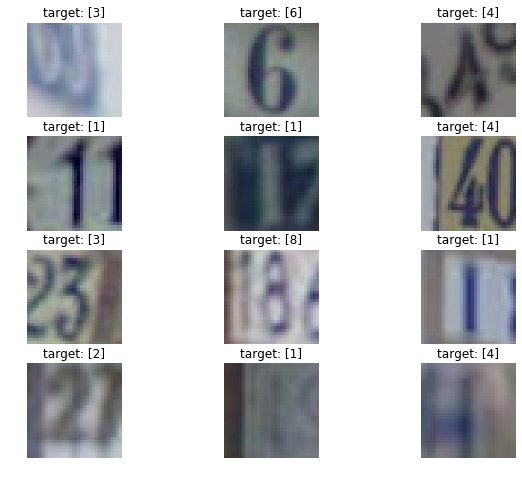

In [21]:
%matplotlib inline

# create figure
fig = plt.figure(figsize=(10, 8))
  
# setting values to rows and column variables
rows = 4
columns = 3
  
for i in range(12):
    # showing image
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(x_sample[i])
    plt.axis('off')
    plt.title('target: {}'.format(y_sample[i]))
  

In [13]:
#Avg all color channels
X_gs_train = np.mean(X_train, axis=3, keepdims=True)
X_gs_test = np.mean(X_test, axis=3, keepdims=True)

print(X_gs_train.shape, X_gs_test.shape)

(73257, 32, 32, 1) (26032, 32, 32, 1)


In [23]:
# Randomly Choose 12 images and labels
idx = np.random.choice(np.arange(X_train.shape[0]), 12)
x_sample = np.squeeze(X_gs_train[idx], axis=3)
y_sample = y_train[idx]


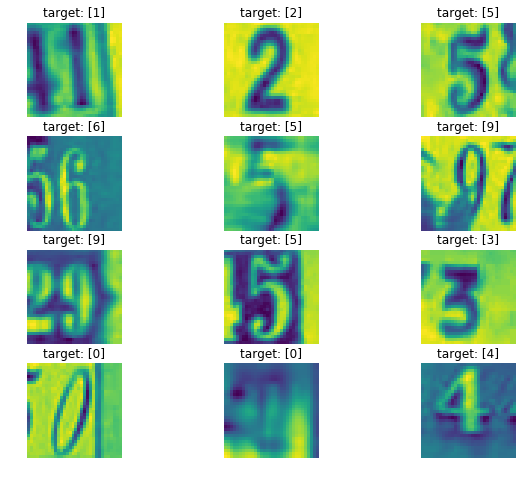

In [24]:
# create figure
fig1 = plt.figure(figsize=(10, 8))
  
# setting values to rows and column variables
rows = 4
columns = 3
  
for i in range(12):
    # showing image
    fig1.add_subplot(rows, columns, i+1)
    plt.imshow(x_sample[i])
    plt.axis('off')
    plt.title('target: {}'.format(y_sample[i]))

In [7]:
from tensorflow.keras.utils import to_categorical

#Make labels categorical
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [6]:
def get_mlp_model():
    model = tf.keras.Sequential([
            Flatten(input_shape=(32,32,1)),
            Dense(64, activation='relu'),
            Dense(64, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax')
    ])
    
    return model

In [56]:
model = get_mlp_model()
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                65600     
_________________________________________________________________
dense_41 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_42 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_43 (Dense)             (None, 10)                650       
Total params: 74,570
Trainable params: 74,570
Non-trainable params: 0
_________________________________________________________________


In [57]:
es_callback = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
mc_callback = ModelCheckpoint('chkpt_dense/checkpoint', save_weights_only=True, save_best_only=True)
lr_callback = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=2)

opt = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-05, name='Adam')

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_gs_train, y_train_cat, epochs=30, batch_size=64, validation_split=0.1, callbacks=[es_callback, mc_callback, lr_callback])

Train on 65931 samples, validate on 7326 samples
Epoch 1/30
65931/65931 [==============================] - 19s 294us/sample - loss: 3.4241 - accuracy: 0.1819 - val_loss: 2.0914 - val_accuracy: 0.2796
Epoch 2/30
65931/65931 [==============================] - 18s 269us/sample - loss: 1.8167 - accuracy: 0.3854 - val_loss: 1.5298 - val_accuracy: 0.4930
Epoch 3/30
65931/65931 [==============================] - 18s 268us/sample - loss: 1.5528 - accuracy: 0.4922 - val_loss: 1.4380 - val_accuracy: 0.5302
Epoch 4/30
65931/65931 [==============================] - 18s 271us/sample - loss: 1.4602 - accuracy: 0.5250 - val_loss: 1.3755 - val_accuracy: 0.5501
Epoch 5/30
65931/65931 [==============================] - 18s 270us/sample - loss: 1.3972 - accuracy: 0.5491 - val_loss: 1.3556 - val_accuracy: 0.5637
Epoch 6/30
65931/65931 [==============================] - 18s 267us/sample - loss: 1.3777 - accuracy: 0.5566 - val_loss: 1.3841 - val_accuracy: 0.5591
Epoch 7/30
65931/65931 [=====================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


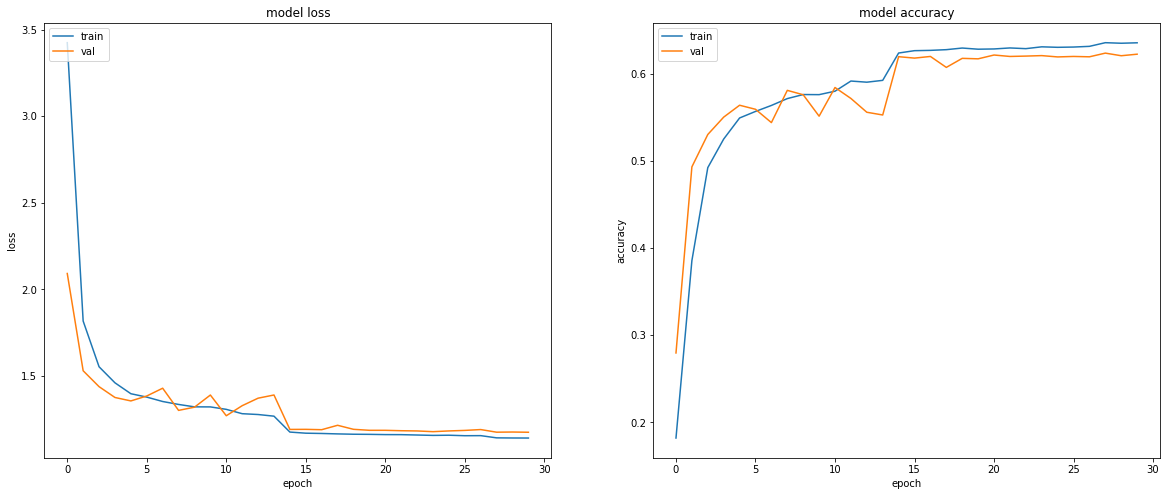

In [58]:
import pandas as pd
print(history.history.keys())
pd.DataFrame(history.history)

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [59]:
model.evaluate(X_gs_test, y_test_cat, verbose=0)

[1.2899548906670366, 0.5994929]

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout

In [7]:
def get_cnn_model():
    model = Sequential([
        Conv2D(16, kernel_size=3, padding='same', input_shape=(32,32,1)),
        BatchNormalization(),
        MaxPool2D(),
        Dropout(0.3),
        Conv2D(8, kernel_size=3, padding='same'),
        BatchNormalization(),
        MaxPool2D(),
        Dropout(0.3),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(10, activation='softmax')
    ])
    
    return model

In [39]:
model=get_cnn_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 16)        160       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 8)         1160      
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 8)         32        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 8)          

In [40]:
es_callback = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
mc_callback = ModelCheckpoint('chkpt_cnn/checkpoint', save_weights_only=True, save_best_only=True)
lr_callback = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=2)

opt = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-05, name='Adam')

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_gs_train, y_train_cat, epochs=30, batch_size=64, validation_split=0.1, callbacks=[es_callback, mc_callback, lr_callback])

Train on 65931 samples, validate on 7326 samples
Epoch 1/30
65931/65931 [==============================] - 296s 4ms/sample - loss: 1.8570 - accuracy: 0.3441 - val_loss: 1.0829 - val_accuracy: 0.6657
Epoch 2/30
65931/65931 [==============================] - 291s 4ms/sample - loss: 0.9852 - accuracy: 0.6926 - val_loss: 0.6959 - val_accuracy: 0.7891
Epoch 3/30
65931/65931 [==============================] - 289s 4ms/sample - loss: 0.7745 - accuracy: 0.7642 - val_loss: 0.6028 - val_accuracy: 0.8200
Epoch 4/30
65931/65931 [==============================] - 292s 4ms/sample - loss: 0.6931 - accuracy: 0.7901 - val_loss: 0.5295 - val_accuracy: 0.8485
Epoch 5/30
65931/65931 [==============================] - 287s 4ms/sample - loss: 0.6490 - accuracy: 0.8037 - val_loss: 0.5270 - val_accuracy: 0.8445
Epoch 6/30
65931/65931 [==============================] - 291s 4ms/sample - loss: 0.6173 - accuracy: 0.8115 - val_loss: 0.4902 - val_accuracy: 0.8571
Epoch 7/30
65931/65931 [===========================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


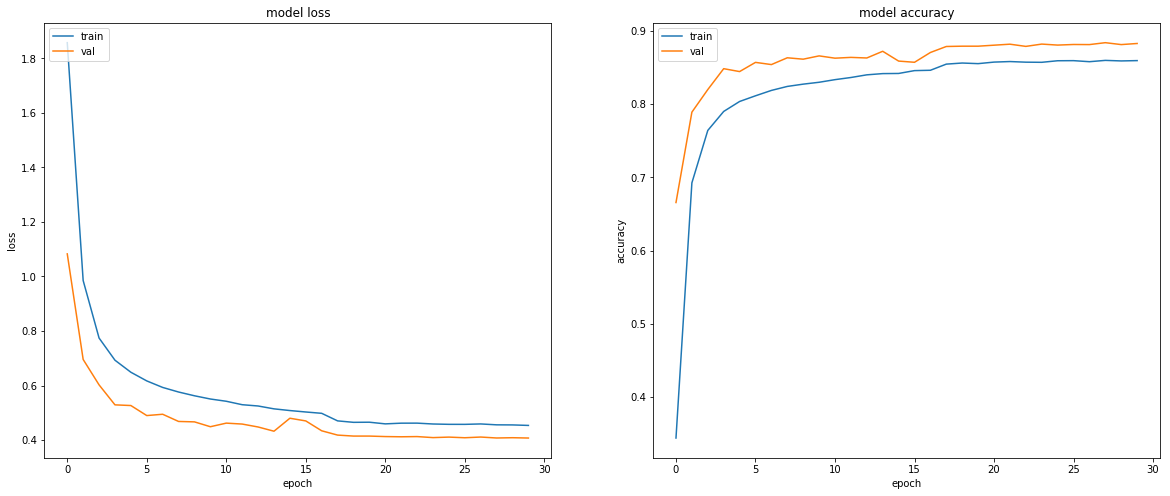

In [41]:
import pandas as pd
print(history.history.keys())
pd.DataFrame(history.history)

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [42]:
model.evaluate(X_gs_test, y_test_cat, verbose=0)

[0.48289720841855743, 0.86032575]

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [8]:
#Load MLP model with best weights
model_mlp = get_mlp_model()
model_mlp.load_weights('chkpt_dense/checkpoint')

In [11]:
#Load CNN model with best weights
model_cnn = get_cnn_model()
model_cnn.load_weights('chkpt_cnn/checkpoint')

In [14]:
#Grab 5 samples from test data
idx = np.random.choice(np.arange(X_gs_test.shape[0]), 5)
x_sample_pred = X_gs_test[idx]
x_sample_show = np.squeeze(X_gs_test[idx], axis=3)
y_sample = y_test[idx]

Text(0.5, 0.98, 'MLP Model Target vs Prediction')

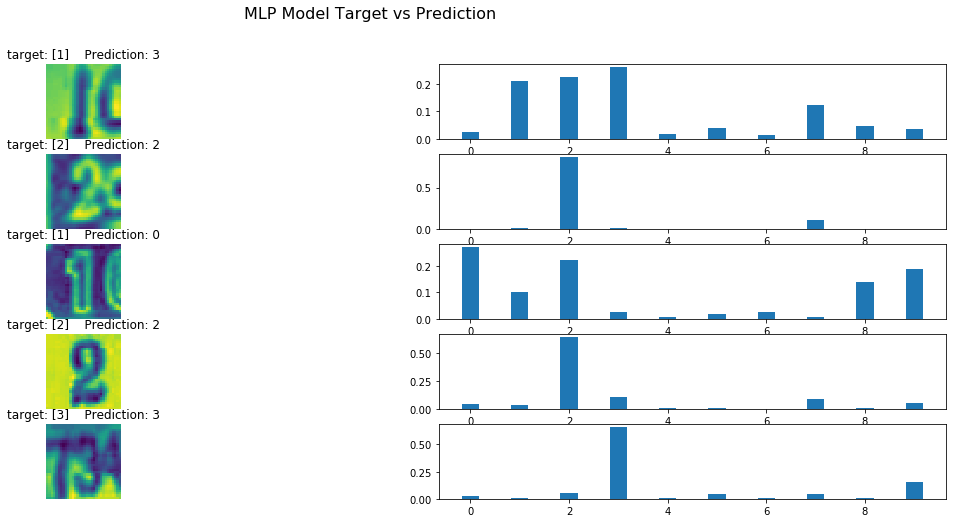

In [21]:
#Let's look at MLP Model First

x_predict = model_mlp.predict(x_sample_pred, verbose=0)
pred = np.argmax(x_predict, axis=1)
#print(x_predict)
#print(x_predict[0])

# create figure
fig1 = plt.figure(figsize=(20, 8))
  
# setting values to rows and column variables
rows = 5
columns = 2  
width = 0.35

for i in range(5):
    # showing image
    fig1.add_subplot(rows, columns, i*2 + 1)
    plt.axis('off')
    plt.title('target: {}    Prediction: {}'.format(y_sample[i], pred[i]))
    plt.imshow(x_sample_show[i])
    
    # Showing bar graph
    fig1.add_subplot(rows, columns, i*2 + 2)
    plt.bar(np.arange(0,10) , height=x_predict[i], width=width)

#Add overall title
fig1.suptitle('MLP Model Target vs Prediction', fontsize=16)


Text(0.5, 0.98, 'CNN Model Target vs Prediction')

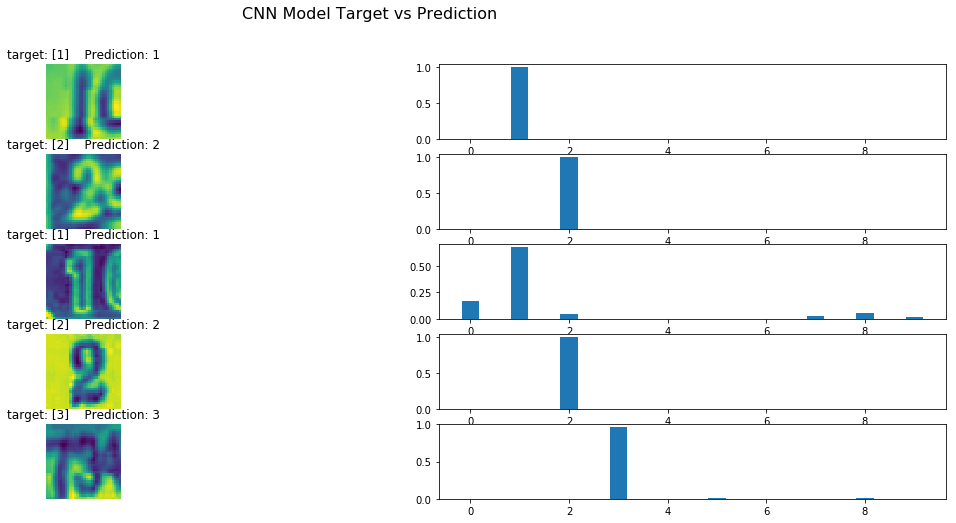

In [23]:
#Let's look at CNN Model Next

x_predict = model_cnn.predict(x_sample_pred, verbose=0)
pred = np.argmax(x_predict, axis=1)

# create figure
fig1 = plt.figure(figsize=(20, 8))
  
# setting values to rows and column variables
rows = 5
columns = 2    

for i in range(5):
    # showing image
    fig1.add_subplot(rows, columns, i*2 + 1)
    plt.axis('off')
    plt.title('target: {}    Prediction: {}'.format(y_sample[i], pred[i]))
    plt.imshow(x_sample_show[i])
    
    # Showing bar graph
    fig1.add_subplot(rows, columns, i*2 + 2)
    plt.bar(np.arange(0,10) , height=x_predict[i], width=width)
    
fig1.suptitle('CNN Model Target vs Prediction', fontsize=16)